# IMPORT LIBS

In [1]:
import sys
sys.path.insert(1, "/home/lucas/AffectiveComputing")

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from libs.pre_processing import PreProcessing 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer
from warnings import filterwarnings
import matplotlib.pyplot as plt
import tensorflow as tf
from os import environ
import seaborn as sns 
import pandas as pd
import numpy as np


model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

pp = PreProcessing()
filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tqdm-4.65.0-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-28 10:33:57.301489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 10:33:57.653830: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 10:33:57.656881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 10:33:58.549194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading 

# LOAD DATA

In [2]:
path = '/home/lucas/AffectiveComputing/data_source/ceweb/test.csv'
data = pd.read_csv(path, delimiter='\t')


In [3]:
emotion_name = {0: 'admiração', 1: 'diversão', 2: 'raiva', 3: 'aborrecimento',
                4: 'provação', 5: 'confusão', 6: 'curiosidade', 7: 'desejo',
                8: 'decepção', 9: 'desaprovação', 10: 'nojo', 11: 'vergonha', 
                12: 'entusiasmo', 13: 'medo', 14: 'gratidão', 15: 'luto', 
                16: 'alegria', 17: 'amor', 18: 'nervosismo', 19: 'otimismo',
                20: 'orgulho', 21: 'alívio', 22: 'remorso', 23: 'tristeza',  
                24: 'surpresa', 25: 'saudade', 26: 'inveja', 27: 'compaixão'}
emotion_name

{0: 'admiração',
 1: 'diversão',
 2: 'raiva',
 3: 'aborrecimento',
 4: 'provação',
 5: 'confusão',
 6: 'curiosidade',
 7: 'desejo',
 8: 'decepção',
 9: 'desaprovação',
 10: 'nojo',
 11: 'vergonha',
 12: 'entusiasmo',
 13: 'medo',
 14: 'gratidão',
 15: 'luto',
 16: 'alegria',
 17: 'amor',
 18: 'nervosismo',
 19: 'otimismo',
 20: 'orgulho',
 21: 'alívio',
 22: 'remorso',
 23: 'tristeza',
 24: 'surpresa',
 25: 'saudade',
 26: 'inveja',
 27: 'compaixão'}

In [4]:
def _preprocessing_train(dataframe, column):
    dataframe = pp.dropnan_and_lowercase(dataframe, column)
    dataframe = pp.change_abbreviations_dataframe(dataframe, column)
    dataframe = pp.drop_size(dataframe, column, 3)
    dataframe = pp.set_category(dataframe, 'categoria')
    dataframe = pp.apply_regex_dataframe(dataframe, column)
    dataframe = pp.shuffled_dataframe(dataframe)
    dataframe = pp.remove_stopwords_dataframe(dataframe, column)
    return dataframe

In [5]:
data = _preprocessing_train(data, "tweet")

texts = data.tweet
labels = np.array(data.categoria.tolist())

texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokens_train = [tokenizer.encode(text, add_special_tokens=True) for text in texts_train]
tokens_val = [tokenizer.encode(text, add_special_tokens=True) for text in texts_val]

texts_train_processed = [' '.join(map(str, tokens)) for tokens in tokens_train]
texts_val_processed = [' '.join(map(str, tokens)) for tokens in tokens_val]

# NAIVE BAYES - TF-IDF

In [6]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3)],
    'tfidfvectorizer__max_features': [5000, 10000, None],
    'multinomialnb__alpha': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(texts_train_processed, labels_train)

best_params = grid_search.best_params_

predictions = grid_search.predict(texts_val_processed)

accuracy = accuracy_score(labels_val, predictions)
print(f'Melhores valores para os hiperparâmetros: {best_params}')
print(f'Acurácia com o melhor modelo: {accuracy}')

Melhores valores para os hiperparâmetros: {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__max_features': 5000, 'tfidfvectorizer__ngram_range': (1, 2)}
Acurácia com o melhor modelo: 0.5769692123150739


In [8]:
labels_val_names = [emotion_name[label] for label in labels_val]
pred_labels_names = [emotion_name[label] for label in predictions]
report = classification_report(labels_val_names, pred_labels_names)

print(report)

               precision    recall  f1-score   support

aborrecimento       0.84      0.56      0.67        57
    admiração       0.64      0.59      0.62       129
      alegria       0.55      0.34      0.42       111
       alívio       0.73      0.63      0.67        59
         amor       0.66      0.53      0.59        79
    compaixão       0.87      0.27      0.41        49
     confusão       0.46      0.87      0.60       279
  curiosidade       0.63      0.51      0.56        61
     decepção       0.80      0.67      0.73        42
 desaprovação       0.95      0.56      0.71        32
       desejo       0.39      0.51      0.44       200
     diversão       0.52      0.71      0.60       203
   entusiasmo       0.61      0.47      0.54       120
     gratidão       0.00      0.00      0.00         5
       inveja       0.82      0.51      0.63        70
         luto       0.56      0.32      0.41        72
         medo       0.60      0.58      0.59       115
   nervos

In [9]:
report_tf = classification_report(labels_val_names, pred_labels_names, output_dict=True)
df_report_tf = pd.DataFrame(report_tf).transpose()
df_report_tf

,precision,recall,f1-score,support
aborrecimento,0.842105,0.561404,0.673684,57.000000
admiração,0.644068,0.589147,0.615385,129.000000
alegria,0.550725,0.342342,0.422222,111.000000
alívio,0.725490,0.627119,0.672727,59.000000
amor,0.656250,0.531646,0.587413,79.000000
compaixão,0.866667,0.265306,0.406250,49.000000
confusão,0.460076,0.867384,0.601242,279.000000
curiosidade,0.632653,0.508197,0.563636,61.000000
decepção,0.800000,0.666667,0.727273,42.000000
desaprovação,0.947368,0.562500,0.705882,32.000000


# NAIVE BAYES - COUNTER VECTORIZER

In [11]:
model = make_pipeline(CountVectorizer(), MultinomialNB())

param_grid = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3)],
    'countvectorizer__max_features': [5000, 10000, None],
    'multinomialnb__alpha': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(texts_train_processed, labels_train)

best_params = grid_search.best_params_

predictions = grid_search.predict(texts_val_processed)

accuracy = accuracy_score(labels_val, predictions)
print(f'Melhores valores para os hiperparâmetros: {best_params}')
print(f'Acurácia com o melhor modelo: {accuracy}')

Melhores valores para os hiperparâmetros: {'countvectorizer__max_features': 5000, 'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 1.0}
Acurácia com o melhor modelo: 0.6093562574970012


In [12]:
labels_val_names = [emotion_name[label] for label in labels_val]
pred_labels_names = [emotion_name[label] for label in predictions]
report = classification_report(labels_val_names, pred_labels_names)

print(report)

               precision    recall  f1-score   support

aborrecimento       0.71      0.61      0.66        57
    admiração       0.65      0.67      0.66       129
      alegria       0.56      0.40      0.47       111
       alívio       0.70      0.63      0.66        59
         amor       0.66      0.53      0.59        79
    compaixão       0.75      0.24      0.37        49
     confusão       0.53      0.86      0.66       279
  curiosidade       0.59      0.52      0.56        61
     decepção       0.86      0.71      0.78        42
 desaprovação       0.77      0.53      0.63        32
       desejo       0.45      0.56      0.50       200
     diversão       0.65      0.64      0.65       203
   entusiasmo       0.63      0.59      0.61       120
     gratidão       0.00      0.00      0.00         5
       inveja       0.78      0.60      0.68        70
         luto       0.60      0.36      0.45        72
         medo       0.54      0.58      0.56       115
   nervos

In [13]:
report_cv = classification_report(labels_val_names, pred_labels_names, output_dict=True)
df_report_cv = pd.DataFrame(report_cv).transpose()
df_report_cv

,precision,recall,f1-score,support
aborrecimento,0.714286,0.614035,0.660377,57.000000
admiração,0.646617,0.666667,0.656489,129.000000
alegria,0.564103,0.396396,0.465608,111.000000
alívio,0.698113,0.627119,0.660714,59.000000
amor,0.656250,0.531646,0.587413,79.000000
compaixão,0.750000,0.244898,0.369231,49.000000
confusão,0.532151,0.860215,0.657534,279.000000
curiosidade,0.592593,0.524590,0.556522,61.000000
decepção,0.857143,0.714286,0.779221,42.000000
desaprovação,0.772727,0.531250,0.629630,32.000000


## GENERAL METRICS

In [73]:
selected_rows = ['accuracy', 'macro avg', 'weighted avg']
df_report_tf_m = df_report_tf.loc[selected_rows]
df_report_cv_m = df_report_cv.loc[selected_rows]

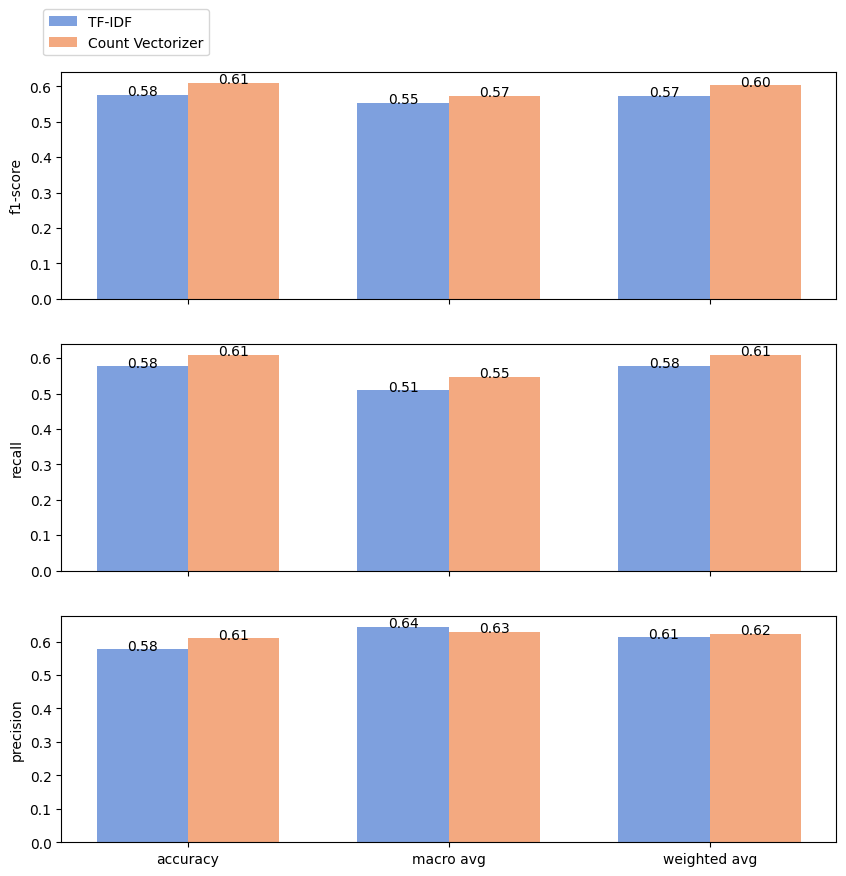

In [90]:
metrics_to_compare = ['f1-score', 'recall', 'precision']

# Configuração do gráfico
fig, axes = plt.subplots(nrows=len(metrics_to_compare), ncols=1, figsize=(10, 10), sharex=True)

# Usar paleta de cores mais atraente do Seaborn
colors = sns.color_palette("muted", n_colors=2)

# Largura ajustada das barras
bar_width = 0.35

# Iterar sobre as métricas e criar gráficos de barras para cada métrica
for i, metric in enumerate(metrics_to_compare):
    tf_values = df_report_tf_m[metric]
    cv_values = df_report_cv_m[metric]

    # Barra para TF-IDF
    axes[i].bar(np.arange(len(df_report_tf_m)) - bar_width/2, tf_values, label=f'TF-IDF {metric}', width=bar_width, color=colors[0], alpha=0.7)
    
    # Barra para Count Vectorizer
    axes[i].bar(np.arange(len(df_report_cv_m)) + bar_width/2, cv_values, label=f'Count Vectorizer {metric}', width=bar_width, color=colors[1], alpha=0.7)
    
    # Adicionar rótulos nas barras
    for j, value in enumerate(tf_values):
        axes[i].text(j - bar_width/2, value + 0.01, f'{value:.2f}', ha='center', va='center', color='black')

    for j, value in enumerate(cv_values):
        axes[i].text(j + bar_width/2, value + 0.01, f'{value:.2f}', ha='center', va='center', color='black')

    axes[i].set_ylabel(metric)

# Adicionar uma única legenda fora dos subplots para ambas as técnicas
fig.legend(handles=[plt.Rectangle((0,0),1,1,fc=colors[0], alpha=0.7), plt.Rectangle((0,0),1,1,fc=colors[1], alpha=0.7)],
           labels=['TF-IDF', 'Count Vectorizer'], 
           loc='upper left', bbox_to_anchor=(0.1, 0.95))

# Remover a grade
for ax in axes:
    ax.grid(False)

# Configurações adicionais do gráfico
plt.xticks(np.arange(len(df_report_tf_m)), df_report_tf_m.index)

plt.show()


## METRICS FOR EACH EMOTION

In [17]:
df_report_tf_u = df_report_tf.drop(['accuracy', 'macro avg', 'weighted avg'])
df_report_cv_u = df_report_cv.drop(['accuracy', 'macro avg', 'weighted avg'])

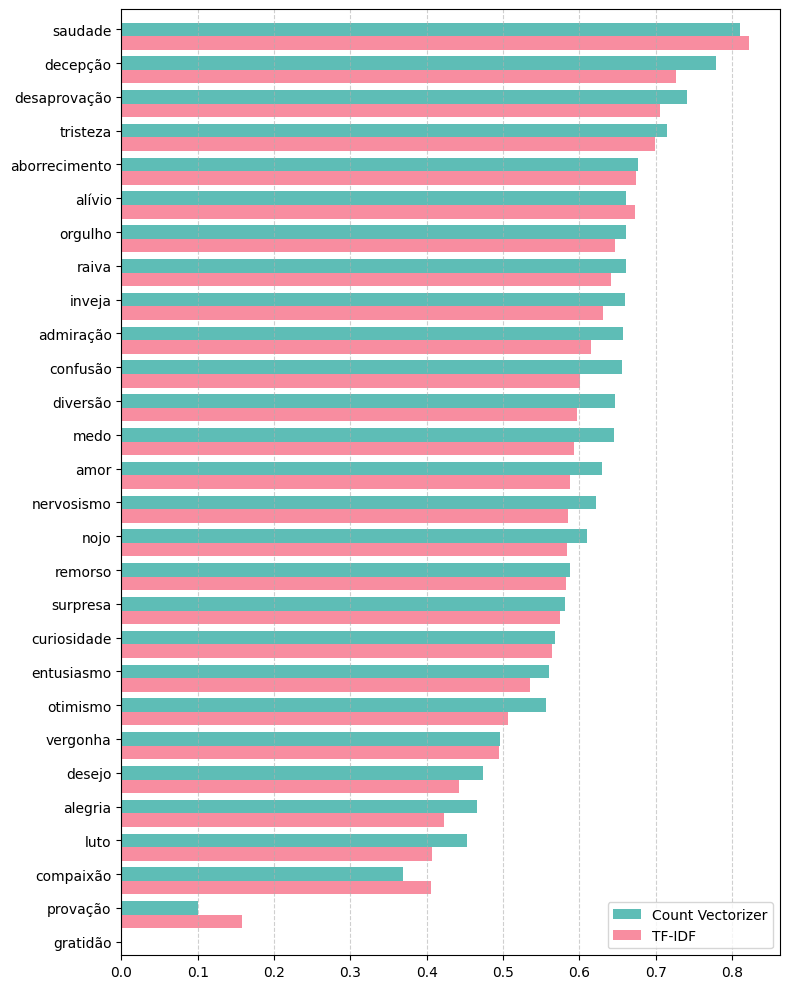

In [113]:
metric_to_compare = 'f1-score'


df_report_tf_u = df_report_tf_u.sort_values(by=metric_to_compare, ascending=True)
df_report_cv_u = df_report_cv_u.sort_values(by=metric_to_compare, ascending=True)


colors = sns.color_palette("husl", 2)

fig, ax = plt.subplots(figsize=(8, 10))

bar_height = 0.4
bar_positions_tf = np.arange(len(df_report_tf_u))
bar_positions_cv = bar_positions_tf + bar_height

ax.barh(bar_positions_cv, df_report_cv_u[metric_to_compare], height=bar_height, label='Count Vectorizer', color=colors[1], alpha=0.8)
ax.barh(bar_positions_tf, df_report_tf_u[metric_to_compare], height=bar_height, label='TF-IDF', color=colors[0], alpha=0.8)

ax.set_yticks(bar_positions_tf + bar_height)
ax.set_yticklabels(df_report_tf_u.index)

ax.legend(loc='best')

ax.grid(axis='x', linestyle='--', alpha=0.6)

ax.set_ylim(0, len(df_report_tf_u))
plt.tight_layout()
plt.show()
